In [44]:
import csv
import cv2
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Flatten, Dropout, Lambda,Activation
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D 
from keras.models import Sequential
from keras.layers import Flatten, Dense

In [21]:
samples = []
def read_img(csv_path):
    with open(csv_path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            samples.append(line)
        return samples[1:]
csv_samples = read_img('./data/driving_log.csv')

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(csv_samples, test_size=0.2)

In [22]:
np.array(train_samples)[5][2]

' IMG/right_2016_12_01_13_39_13_263.jpg'

In [33]:
def flipped(image):
    return np.fliplr(image)

In [34]:
import sklearn
def generator(samples, batch_size=128):
    num_samples = len(samples)
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]
            images = []
            angles = []
            data_path = './data/IMG'
            for batch_sample in batch_samples:
                #name = './IMG/'+batch_sample[0].split('/')[-1]
                center_img = cv2.imread(data_path + batch_sample[0].split('IMG')[1])
                center_img_flip = flipped(center_img)
                left_img = cv2.imread(data_path + batch_sample[1].split('IMG')[1])
                left_img_flip = flipped(left_img)
                right_img = cv2.imread(data_path + batch_sample[2].split('IMG')[1])
                right_img_flip = flipped(right_img)
                center_angle = float(batch_sample[3])
                center_angle_flip = - center_angle
                left_angle = float(batch_sample[3]) + 0.1
                left_angle_flip = - left_angle
                right_angle = float(batch_sample[3]) - 0.1
                right_angle_flip = - right_angle
                if np.random.rand() > 0.5:
                    images.append(center_img)
                    images.append(left_img)
                    images.append(right_img)
                    angles.append(center_angle)
                    angles.append(left_angle)
                    angles.append(right_angle)
                else:
                    images.append(center_img_flip)
                    images.append(left_img_flip)
                    images.append(right_img_flip)
                    angles.append(center_angle_flip)
                    angles.append(left_angle_flip)
                    angles.append(right_angle_flip)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield sklearn.utils.shuffle(X_train, y_train)

# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

In [35]:
for i in range(10):
    my_output = (next(train_generator))
    
print(my_output)

[array([[[[ 37,  16,   8],
         [ 47,  30,  21],
         [ 21,  12,   2],
         ..., 
         [192, 148, 117],
         [193, 149, 118],
         [193, 149, 118]],

        [[157, 135, 124],
         [141, 123, 112],
         [ 40,  30,  20],
         ..., 
         [193, 149, 118],
         [193, 149, 118],
         [194, 150, 119]],

        [[164, 138, 124],
         [ 34,  12,   0],
         [ 22,   6,   0],
         ..., 
         [194, 150, 119],
         [195, 151, 120],
         [195, 151, 120]],

        ..., 
        [[ 69,  83,  81],
         [ 81,  95,  93],
         [ 89, 103, 101],
         ..., 
         [134, 149, 145],
         [136, 151, 147],
         [138, 153, 149]],

        [[ 93, 107, 105],
         [ 85,  99,  97],
         [ 79,  93,  91],
         ..., 
         [130, 144, 138],
         [132, 146, 140],
         [132, 146, 140]],

        [[ 72,  86,  84],
         [ 89, 103, 101],
         [111, 125, 123],
         ..., 
         [136, 150, 144],
 

Epoch 1/6
6144/6428 [===========================>..] - ETA: 0s - loss: 0.0297

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6528/6428 [==============================] - 22s - loss: 0.0288 - val_loss: 0.0184
Epoch 2/6
6612/6428 [==============================] - 22s - loss: 0.0160 - val_loss: 0.0129
Epoch 3/6
6528/6428 [==============================] - 21s - loss: 0.0134 - val_loss: 0.0141
Epoch 4/6
6612/6428 [==============================] - 22s - loss: 0.0136 - val_loss: 0.0121
Epoch 5/6
6528/6428 [==============================] - 21s - loss: 0.0129 - val_loss: 0.0140
Epoch 6/6
6528/6428 [==============================] - 22s - loss: 0.0115 - val_loss: 0.0110
dict_keys(['loss', 'val_loss'])


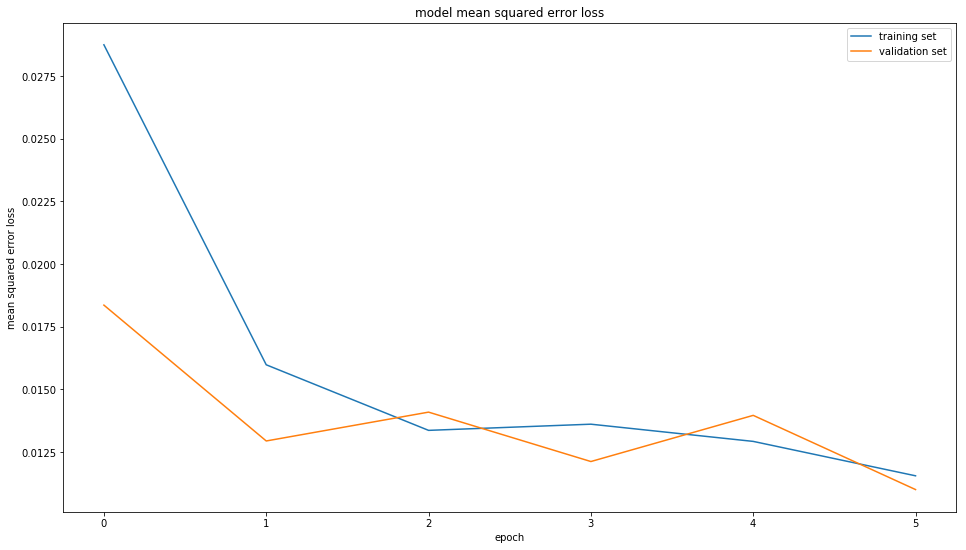

In [ ]:
model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160, 320, 3)))
model.add(Cropping2D(cropping=((50, 20), (0, 0))))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))
model.add(Convolution2D(64, 3, 3, activation='relu'))

model.add(Flatten())

model.add(Dense(100))
model.add(Activation('elu'))
model.add(Dropout(0.2))
model.add(Dense(50))
model.add(Activation('elu'))
model.add(Dropout(0.2))
model.add(Dense(10))
model.add(Activation('elu'))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=6, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())
plt.rcParams['figure.figsize'] = (16, 9)
### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()
model.save('model.h5')

In [ ]:
from keras.models import Model
import matplotlib.pyplot as plt

history_object = model.fit_generator(train_generator, samples_per_epoch =
    len(train_samples), validation_data = 
    validation_generator,
    nb_val_samples = len(validation_samples), 
    nb_epoch=10, verbose=1)

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

Epoch 1/10
6228/6428 [============================>.] - ETA: 0s - loss: 0.0120

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


6612/6428 [==============================] - 22s - loss: 0.0120 - val_loss: 0.0139
Epoch 2/10
6528/6428 [==============================] - 21s - loss: 0.0122 - val_loss: 0.0102
Epoch 3/10
3072/6428 [=============>................] - ETA: 9s - loss: 0.0100 